# Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
import warnings

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense,LSTM,Dropout
from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [4]:
warnings.filterwarnings('ignore')

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
tf.test.is_built_with_cuda()

True

# Loading and Visualize the Data

In [7]:
data = pd.read_csv("current_Bill(Aug-00_to_Oct-20).csv",date_parser = True)
data

,No.,Billing Months,Amount (BDT),PT 1,PT 2,PT 3,PT 4
0,1,Aug,1458,1736,988,1158,1569
1,2,Sep,1369,1458,1455,1233,1255
2,3,Oct,1178,1369,1736,988,1158
3,4,Nov,1090,1178,1458,1455,1233
4,5,Dec,1050,1090,1369,1736,988
...,...,...,...,...,...,...,...
238,239,Jun,1270,1258,1616,2059,1632
239,240,Jul,1306,1270,1228,2330,708
240,241,Aug,1005,1306,1258,1616,2059
241,242,Sep,1639,1005,1270,1228,2330


Text(0, 0.5, 'Amount (BDT)')

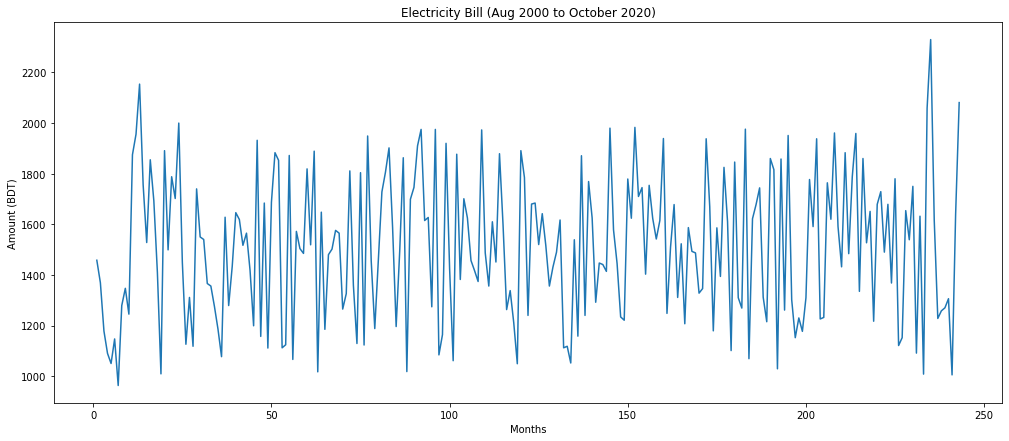

In [8]:
figure(figsize=(17, 7))
plt.plot(data['No.'], data['Amount (BDT)'])
plt.title('Electricity Bill (Aug 2000 to October 2020)')
plt.xlabel('Months')
plt.ylabel('Amount (BDT)')

# Data Preparations

In [9]:
data_train = data [data['No.']<=round(data.shape[0]*.97)].copy()
data_test = data [data['No.']>round(data.shape[0]*.97)].copy()

In [10]:
data_train = data_train.drop(['No.','Billing Months'],axis =1)
data_train

,Amount (BDT),PT 1,PT 2,PT 3,PT 4
0,1458,1736,988,1158,1569
1,1369,1458,1455,1233,1255
2,1178,1369,1736,988,1158
3,1090,1178,1458,1455,1233
4,1050,1090,1369,1736,988
...,...,...,...,...,...
231,1632,1091,1539,1152,1780
232,1008,1632,1750,1654,1121
233,2059,1008,1091,1539,1152
234,2330,2059,1632,1750,1654


In [11]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_train)

In [12]:
X_train=[]
y_train=[]
tar_col = 0 

In [13]:
for i in range (3,data_training.shape[0]):
    X_train.append(data_training[i-3:i])
    y_train.append(data_training[i,tar_col])

In [14]:
X_train, y_train = np.array(X_train),np.array(y_train)

In [15]:
X_train.shape, y_train.shape       #shape = (Observations, no . of batch , features)

((233, 3, 5), (233,))

# Test Data Preparations

In [16]:
past_data=data_train.tail(3)

In [17]:
df = past_data.append (data_test, ignore_index = True)
df = data_test.drop(['No.','Billing Months'],axis = 1)

In [18]:
inputs = scaler.transform(df)
inputs.shape[0]

7

In [19]:
X_test = []
y_test = []

for i in range(3, inputs.shape[0]):
    X_test.append ( inputs [ i-3 : i])
    y_test.append (inputs [i,0])

In [20]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((4, 3, 5), (4,))

# Building Network & Training

In [21]:
regressior = Sequential()
regressior.add(LSTM(units = 5,activation = 'relu',return_sequences =True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressior.add(Dropout(0.1))

regressior.add(LSTM(units = 5,activation = 'relu',return_sequences =True,trainable =True))
regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 10 ,activation = 'relu'))
regressior.add(Dropout(0.1))

regressior.add(Dense(units=1,activation='relu'))

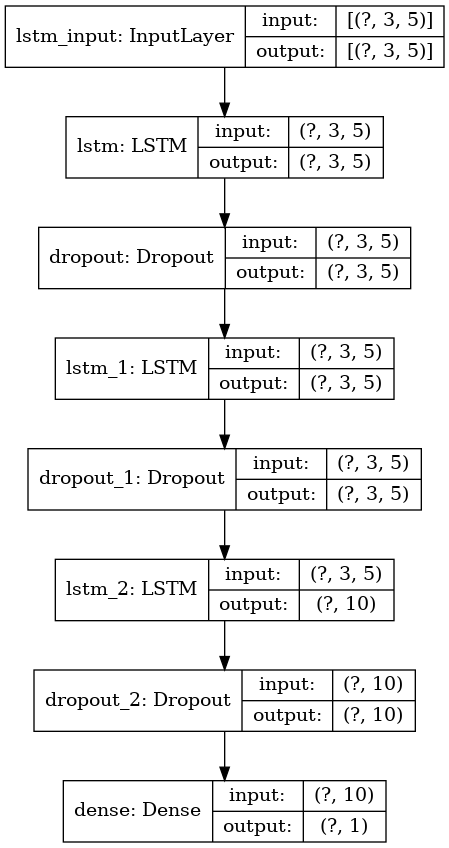

In [22]:
plot_model(regressior, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
regressior.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 5)              220       
_________________________________________________________________
dropout (Dropout)            (None, 3, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [24]:
regressior.compile(optimizer = 'adam',loss='MeanSquaredError', metrics=['MeanAbsoluteError'])

In [25]:
history = regressior.fit(X_train, y_train, 
               epochs =5, 
               batch_size =8,
               validation_data=(X_test, y_test))

Epoch 1/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2072 - mean_absolute_error: 0.4054 - val_loss: 0.2443 - val_mean_absolute_error: 0.3985
Epoch 2/5
30/30 [==============================] - 0s 13ms/step - loss: 0.1992 - mean_absolute_error: 0.3958 - val_loss: 0.2126 - val_mean_absolute_error: 0.3621
Epoch 3/5
30/30 [==============================] - 0s 12ms/step - loss: 0.1466 - mean_absolute_error: 0.3256 - val_loss: 0.1518 - val_mean_absolute_error: 0.3124
Epoch 4/5
30/30 [==============================] - 0s 13ms/step - loss: 0.0874 - mean_absolute_error: 0.2403 - val_loss: 0.0936 - val_mean_absolute_error: 0.2577
Epoch 5/5
30/30 [==============================] - 0s 13ms/step - loss: 0.0486 - mean_absolute_error: 0.1805 - val_loss: 0.0884 - val_mean_absolute_error: 0.2591


In [26]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


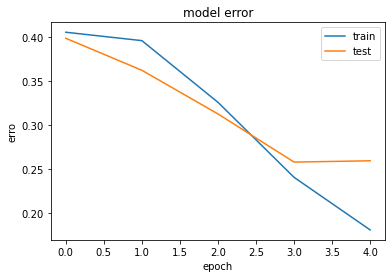

In [27]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('erro')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

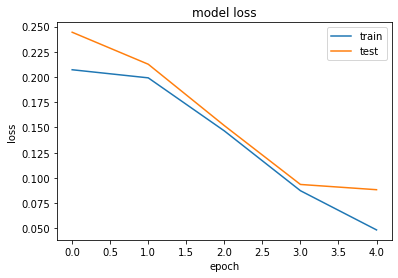

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Prediction and Visualization

In [29]:
y_pred = regressior.predict(X_test)

In [30]:
scaler.scale_

array([0.00073153, 0.00073153, 0.00083963, 0.00083963, 0.00083963])

In [31]:
scale = 1/0.00073153

In [32]:
y_pred = (y_pred*scale)
y_test = (y_test*scale)


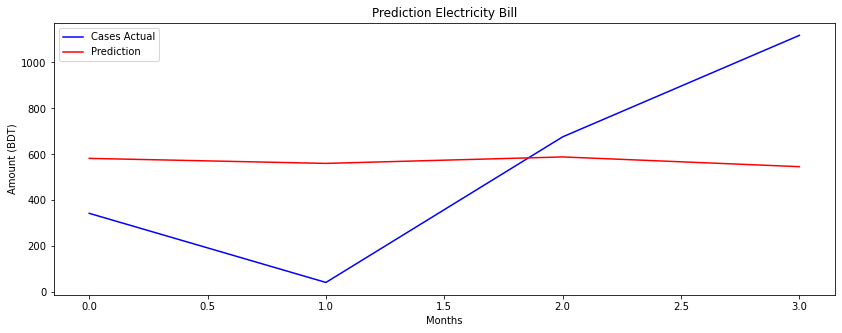

In [33]:
fig=plt.figure (figsize = (14,5))
plt.plot(y_test, color = 'blue', label = 'Cases Actual')
plt.plot(y_pred,color = 'red', label = 'Prediction')
plt.title('Prediction Electricity Bill')
plt.xlabel('Months')
plt.ylabel('Amount (BDT)')
plt.legend()
plt.show()

# Evaluations and Results

In [34]:
_,train_acc = regressior.evaluate(X_train, y_train, verbose=0)
_,test_acc = regressior.evaluate(X_test, y_test, verbose=0)
train_acc,test_acc

(0.17573502659797668, 544.3327026367188)

In [35]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [36]:
rms = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mpe = mape(y_test, y_pred)

In [37]:
print("RMSE : ",rms)
print("R^2 : ",r2)
print("MAPE :",mpe)

RMSE :  406.38976109146927
R^2 :  -0.03333287198482737
MAPE : 346.61706594937016
